In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
from keras.layers import Conv2D, Input, MaxPool2D,Flatten, Dense, Permute, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import GridSearchCV, KFold
from scikeras.wrappers import KerasClassifier,KerasRegressor
from keras.layers import Dropout
from keras.optimizers.legacy import Adam

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv("forestfires.csv")
raw_data.head() 

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:
df = raw_data.copy() 
df.drop(df.columns[11:30],axis=1,inplace = True)

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [5]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [6]:
#There are outliers in the case of area. But we cannot discard it

<Axes: >

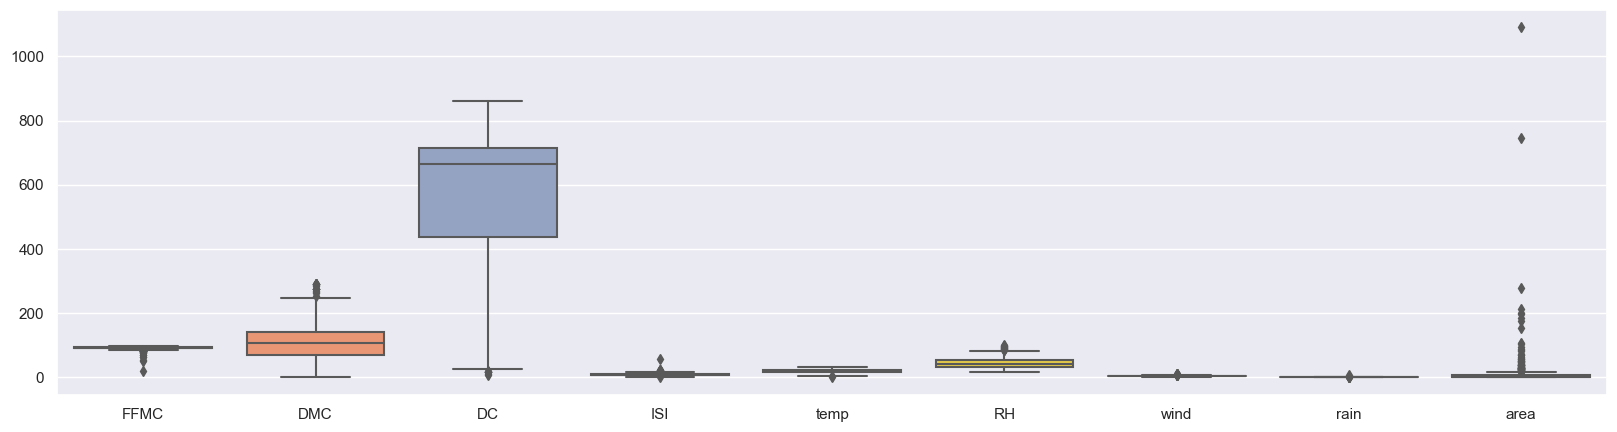

In [7]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 

## Feature Analysis


In [8]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [9]:
df.size_category.value_counts() 

small    378
large    139
Name: size_category, dtype: int64

(array([0, 1]), [Text(0, 0, 'small'), Text(1, 0, 'large')])

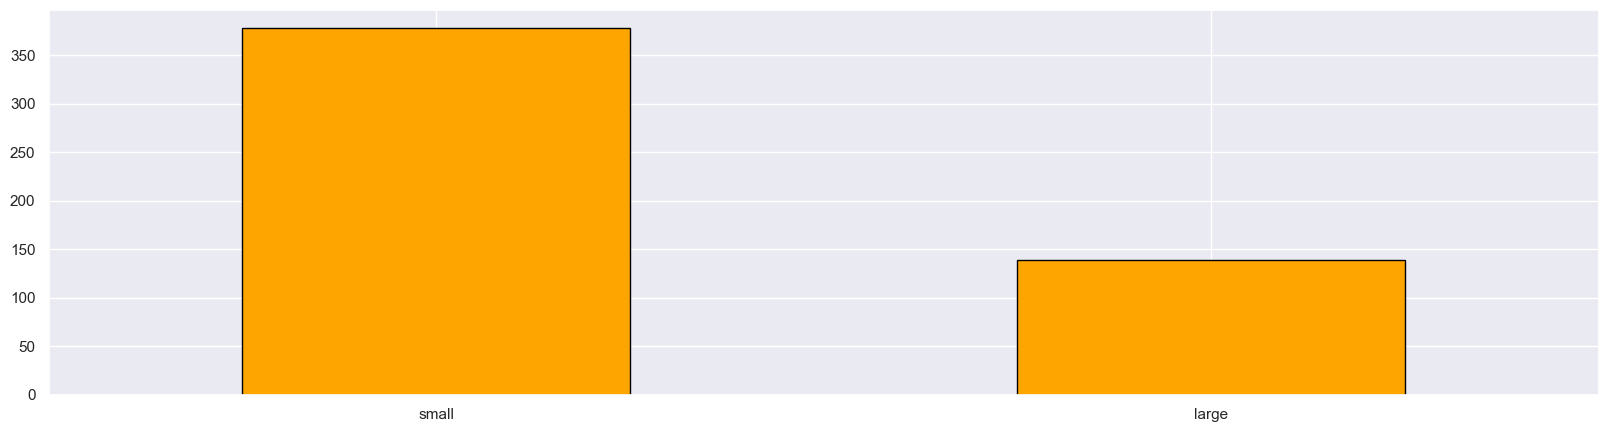

In [10]:
df.size_category.value_counts().plot(kind='bar',color='orange',edgecolor='black')
plt.xticks(rotation=0)

In [11]:
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


# Removing Bias in the Dataset

In [12]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 373, 0: 373})


In [13]:
feature = a
target = b
X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size = 0.3,random_state=10)

In [14]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_standardized=scale.fit_transform(feature)

Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

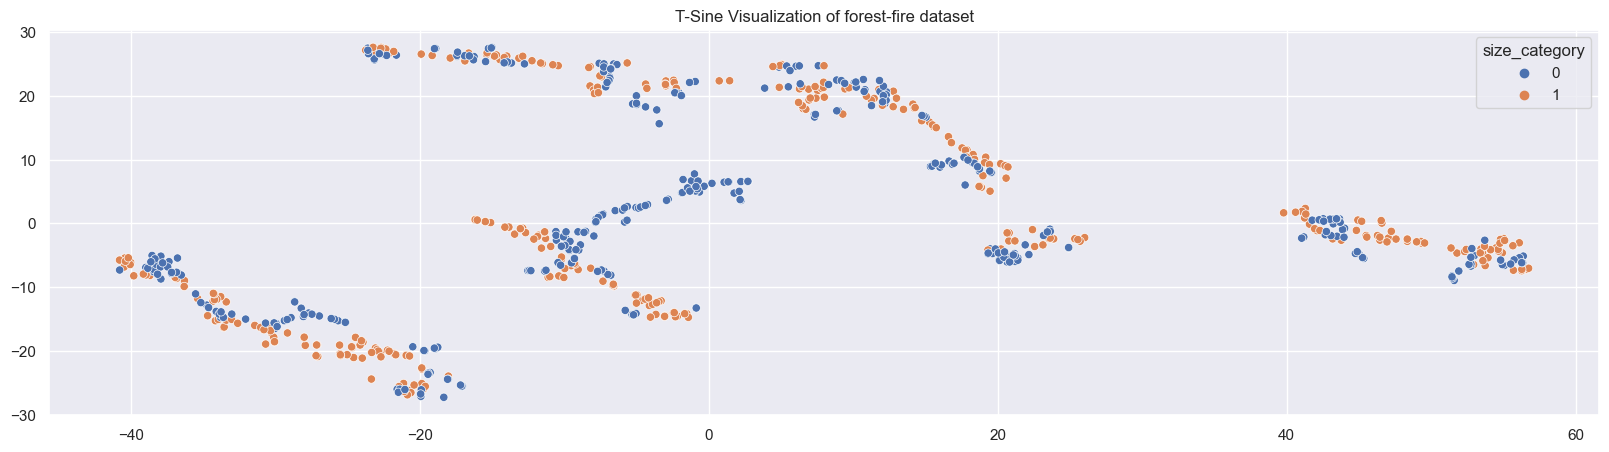

In [15]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(x=data_tsne_pca[:,0],y=data_tsne_pca[:,1],hue=b, palette="deep").set_title('T-Sine Visualization of forest-fire dataset')

## Neural Network Modelling


In [16]:
from keras.models import Sequential
from keras.layers import Dense
import keras

In [17]:
# create model
model1 = Sequential()
model1.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model1.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model1.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist1 = model1.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10)
#At epoch 25 itself our model reaches accuracy of 98% which maybe overfitting



Epoch 1/30


35/35 [==============================] - 1s 7ms/step - loss: 0.6943 - accuracy: 0.5100 - val_loss: 0.6891 - val_accuracy: 0.5549
Epoch 2/30
35/35 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.6246 - val_loss: 0.6644 - val_accuracy: 0.7168
Epoch 3/30
35/35 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.6705 - val_loss: 0.6246 - val_accuracy: 0.5260
Epoch 4/30
35/35 [==============================] - 0s 2ms/step - loss: 0.5722 - accuracy: 0.6734 - val_loss: 0.4885 - val_accuracy: 0.7572
Epoch 5/30
35/35 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.8281 - val_loss: 0.3741 - val_accuracy: 0.8902
Epoch 6/30
35/35 [==============================] - 0s 2ms/step - loss: 0.3867 - accuracy: 0.8367 - val_loss: 0.3917 - val_accuracy: 0.8786
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 0.3050 - accuracy: 0.8883 - val_loss: 0.2238 - val_accuracy: 0.9191
Epoch 8/30
35/35

# Model Evaluation

In [18]:
test_loss, test_acc = model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 1.0000


In [19]:
print(hist1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.025325,0.997135,0.052007,0.982659,25
26,0.088431,0.962751,0.061351,0.982659,26
27,0.027807,0.994269,0.034982,0.988439,27
28,0.046901,0.985673,0.018679,1.000000,28
29,0.028568,0.991404,0.019628,1.000000,29


# Visualize Training History

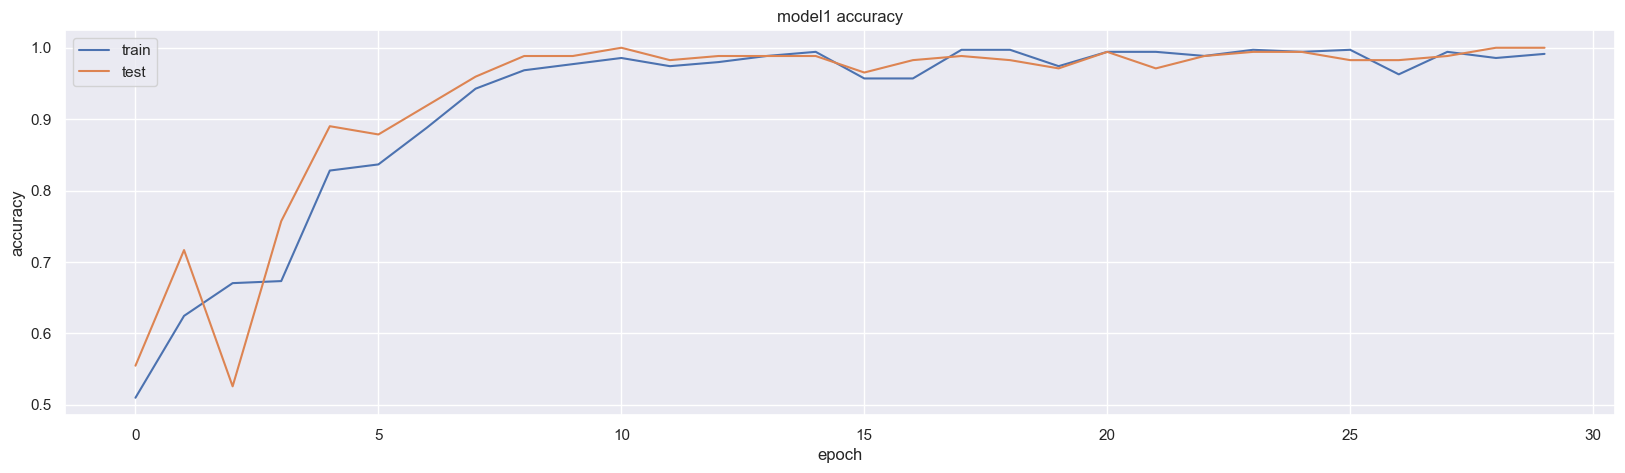

In [21]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


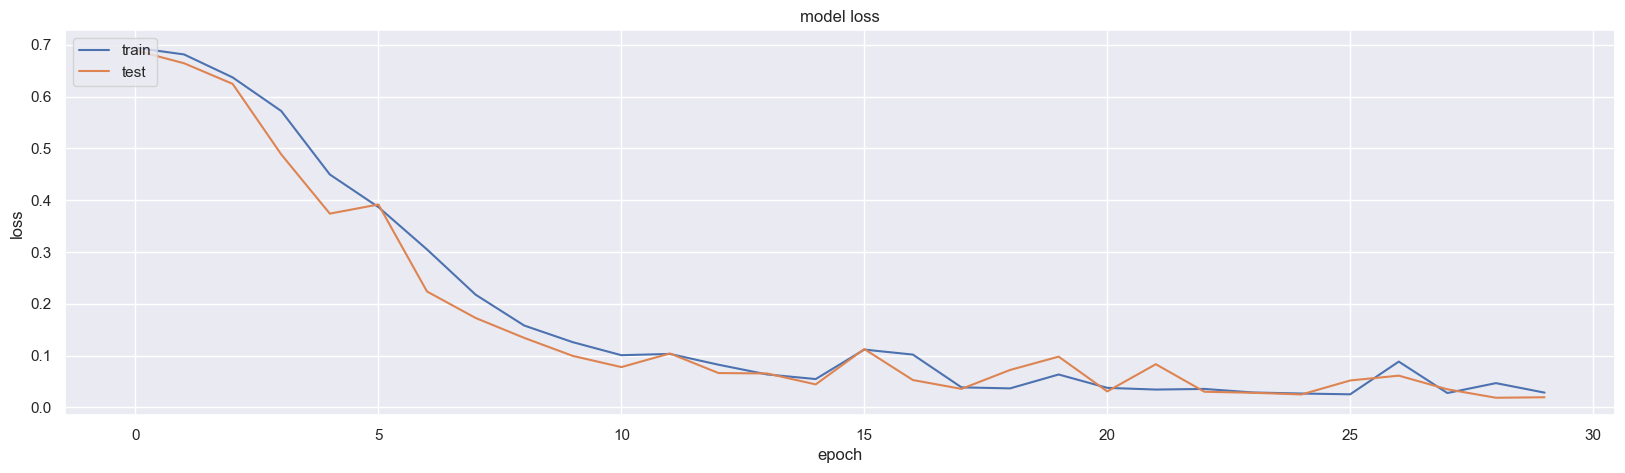

In [22]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #Loss decreases and starts oscillating after 25

In [23]:
def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [24]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [25]:
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,target, test_size = 0.3)

In [26]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [27]:
from sklearn.metrics import confusion_matrix,classification_report
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       110

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



In [28]:
ypredd=model_fnl.predict(X_test_1)

In [29]:
print(confusion_matrix(y_test_1,ypredd))

[[114   0]
 [  0 110]]
